In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
train_set = MNIST('.MNIST', transform=transforms.ToTensor(), train=True, download=True)
val_set = MNIST('.MNIST', transform=transforms.ToTensor(), train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 22497484.46it/s]


Extracting .MNIST/MNIST/raw/train-images-idx3-ubyte.gz to .MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 90602613.18it/s]

Extracting .MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to .MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29384935.08it/s]


Extracting .MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to .MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21922357.62it/s]

Extracting .MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to .MNIST/MNIST/raw



In [3]:
x, y = train_set[0]
x.shape

torch.Size([1, 28, 28])

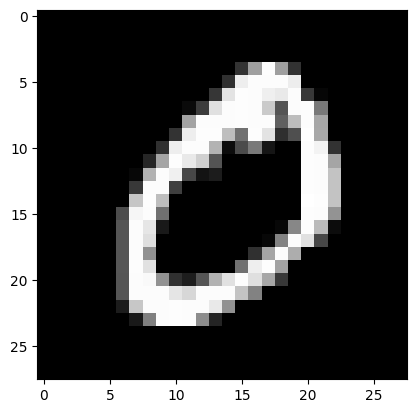

0


In [4]:
import matplotlib.pyplot as plt

x, y = train_set[1]
plt.imshow(x[0,:,:], cmap='gray')
plt.show()
print(y)

In [5]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [6]:
from torch import nn
import torch.nn.functional as F
import torch

class MLP(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.linear1 = nn.Linear(784, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 10)


    def forward(self, x):
        # (batch_size, 1, 28, 28)
        x = torch.flatten(x, start_dim=1)
        # (batch_size, 784)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [7]:
batch = next(iter(train_loader))
batch[1].shape

torch.Size([64])

In [8]:
net = MLP(hidden_size=100)
net(batch[0]).shape

torch.Size([64, 10])

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

79510

In [10]:
def test(net, loader):
    net.eval()

    correct, total = 0, 0

    for batch in loader:
        images, labels = batch[0], batch[1]
        images = images.to('cuda')
        labels = labels.to('cuda')

        with torch.no_grad():
            out = net(images)
        pred = torch.argmax(out, dim=1)

        total += len(pred)
        correct += (pred == labels).cpu().numpy().sum()

    return correct / total

In [11]:
net = MLP(hidden_size=100)
net = net.to('cuda')

In [12]:
test(net, train_loader)

0.13898333333333332

In [13]:
def train(net, train_loader, val_loader, optimizer, epochs=10):
    train_acc, val_acc = [], []
    net.train()

    for epoch in range(epochs):

        correct, total = 0, 0

        for batch in train_loader:
            images, labels = batch[0], batch[1]
            images = images.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            out = net(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(out, dim=1)

            total += len(pred)
            correct += (pred == labels).detach().cpu().numpy().sum()

        train_acc.append(correct / total)
        val_acc.append(test(net, val_loader))

        print(f"Epoch: {epoch}")
        print(f"train accuracy: {train_acc[-1]}")
        print(f"val accuracy: {val_acc[-1]}")

    return train_acc, val_acc

In [14]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [15]:
train_acc, val_acc = train(net, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.9234166666666667
val accuracy: 0.9568
Epoch: 1
train accuracy: 0.9644
val accuracy: 0.9578
Epoch: 2
train accuracy: 0.9754666666666667
val accuracy: 0.9731
Epoch: 3
train accuracy: 0.9783333333333334
val accuracy: 0.9675
Epoch: 4
train accuracy: 0.98125
val accuracy: 0.9739
Epoch: 5
train accuracy: 0.9846333333333334
val accuracy: 0.974
Epoch: 6
train accuracy: 0.9862166666666666
val accuracy: 0.9732
Epoch: 7
train accuracy: 0.9879166666666667
val accuracy: 0.9767
Epoch: 8
train accuracy: 0.9908666666666667
val accuracy: 0.9722
Epoch: 9
train accuracy: 0.99115
val accuracy: 0.9756


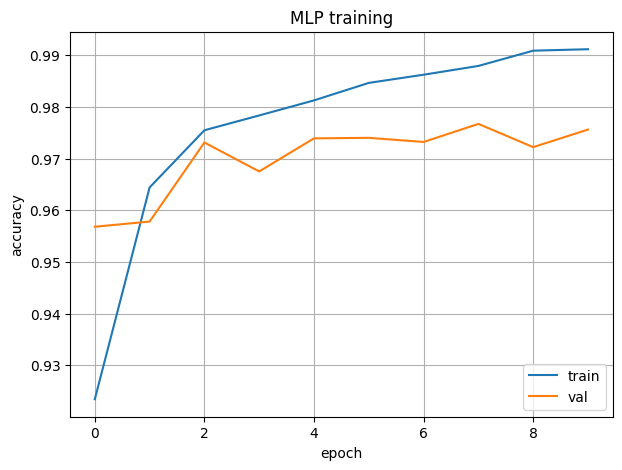

In [16]:
import numpy as np

plt.figure(figsize=(7, 5))

plt.plot(np.arange(10), train_acc, label='train')
plt.plot(np.arange(10), val_acc, label='val')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("MLP training")
plt.show()

In [17]:
torch.save(net.state_dict(), "weights.pt")

In [18]:
!ls

sample_data  weights.pt


In [19]:
net.state_dict().keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])

In [20]:
net = MLP(hidden_size=100).to('cuda')
test(net, val_loader)

0.0898

In [21]:
net.load_state_dict(torch.load("weights.pt"))
test(net, val_loader)

0.9756

In [22]:
#hyperparameters:
# 0) epochs
# 1) learning rate, hidden_size
# 2) optimizer, momentum, batch_size

In [23]:
net = MLP(hidden_size=1000)
net = net.to('cuda')
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_acc, val_acc = train(net, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.93485
val accuracy: 0.9584
Epoch: 1
train accuracy: 0.9736166666666667
val accuracy: 0.9719
Epoch: 2
train accuracy: 0.98275
val accuracy: 0.9784
Epoch: 3
train accuracy: 0.9878833333333333
val accuracy: 0.9791
Epoch: 4
train accuracy: 0.9911166666666666
val accuracy: 0.98
Epoch: 5
train accuracy: 0.99415
val accuracy: 0.9807
Epoch: 6
train accuracy: 0.9965666666666667
val accuracy: 0.9804
Epoch: 7
train accuracy: 0.9981166666666667
val accuracy: 0.9833
Epoch: 8
train accuracy: 0.9989666666666667
val accuracy: 0.9841
Epoch: 9
train accuracy: 0.99945
val accuracy: 0.9856


In [24]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
net = MLP(hidden_size=1000)
net = net.to('cuda')
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_acc, val_acc = train(net, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.921
val accuracy: 0.9677
Epoch: 1
train accuracy: 0.9728833333333333
val accuracy: 0.9744
Epoch: 2
train accuracy: 0.98215
val accuracy: 0.9782
Epoch: 3
train accuracy: 0.9870833333333333
val accuracy: 0.9795
Epoch: 4
train accuracy: 0.99165
val accuracy: 0.9815
Epoch: 5
train accuracy: 0.99405
val accuracy: 0.9805
Epoch: 6
train accuracy: 0.99605
val accuracy: 0.9804
Epoch: 7
train accuracy: 0.9975333333333334
val accuracy: 0.9826
Epoch: 8
train accuracy: 0.9989166666666667
val accuracy: 0.9826
Epoch: 9
train accuracy: 0.99925
val accuracy: 0.9833


In [26]:
net = MLP(hidden_size=1000)
net = net.to('cuda')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train_acc, val_acc = train(net, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.9225833333333333
val accuracy: 0.9618
Epoch: 1
train accuracy: 0.9700666666666666
val accuracy: 0.9722
Epoch: 2
train accuracy: 0.98035
val accuracy: 0.9743
Epoch: 3
train accuracy: 0.9857166666666667
val accuracy: 0.978
Epoch: 4
train accuracy: 0.9902333333333333
val accuracy: 0.9789
Epoch: 5
train accuracy: 0.9926
val accuracy: 0.9817
Epoch: 6
train accuracy: 0.9956333333333334
val accuracy: 0.9792
Epoch: 7
train accuracy: 0.9961333333333333
val accuracy: 0.9807
Epoch: 8
train accuracy: 0.9968833333333333
val accuracy: 0.9794
Epoch: 9
train accuracy: 0.9979166666666667
val accuracy: 0.982
